In [79]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import pandas as pd
import numpy as np

from functions.adjust_cases_functions import prepare_cases
from seir_model import SEIRD

import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

from global_config import config


data_dir            = config.get_property('data_dir_covid')
geo_dir             = config.get_property('geo_dir')
data_dir_mnps       = config.get_property('data_dir_col')
results_dir         = config.get_property('results_dir')
agglomeration_df    = pd.read_csv(os.path.join(data_dir_mnps, 'administrative_division_col_2018.csv')).set_index('poly_id')
agglomerated_folder = os.path.join(data_dir, 'data_stages', 'colombia', 'agglomerated', 'geometry' )

data =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'], dayfirst=True).set_index('poly_id').loc[11001].set_index('date_time')
data = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)    # .rename({'smoothed_num_cases':'num_cases'})
data  = prepare_cases(data, col='num_diseased', cutoff=0) # .rename({'smoothed_num_cases':'num_cases'})

data = data.rename(columns={'smoothed_num_cases': 'confirmed', 'smoothed_num_diseased':'death'})[['confirmed', 'death']]


data = data.iloc[:-14]

In [80]:
import jax
import rpy2
import numpy as np
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
splines = importr("splines")
predict = importr("stats")


In [81]:
df_full = pd.DataFrame({'X':np.arange(len(data.confirmed.tolist())),
                   'Y':np.array(data.confirmed.tolist()),  # add your data here
                    'D': np.array(data.death.tolist())})
                  
df_train =df_full

knots=np.arange(0,len(df_full.X.values)-10,10)
knots = np.concatenate((knots,[len(df_full.X.values)+28]))

#knots= np.concatenate((knots[:-1],[len(df_full.X.values)+28]))
#print (knots)
basis = splines.bs(np.arange(0,len(df_full.X.values)+28),degree=3,knots=knots)


basis_matrix = np.array(basis)
basis_train= basis_matrix[:len(df_full.X.values),:]

#basis_oos = predict.predict(basis,newx=np.arange(1,(len(df_full.X.values)+29)))
basis_oos_matrix =basis_matrix
num_data =basis_matrix.shape[0]
num_basis = basis_matrix.shape[1]

def ExponentialRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
    
    Variables are x_0, ..., x_{T-1}
    
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc) 
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
        
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)        
    '''
    
    log_loc = np.log(loc) + drift * (np.arange(num_steps)+0.)
    
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = log_loc, scale=1.),
            dist.transforms.ExpTransform()
        ]
    )

def LogisticRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
   
    Variables are x_0, ..., x_{T-1}
   
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc)
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
    
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)
    '''
   
    logistic_loc = np.log(loc/(1-loc)) + drift * (np.arange(num_steps)+0.)
   
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = logistic_loc, scale=1.),
            dist.transforms.SigmoidTransform()
        ]
    )

In [82]:
mask = np.zeros((num_data,num_data))

for i in range(num_data):
    mask[i,:(i+31)] = 1
    
    



#case_normalizer = np.max(df_train.Y.values)
df_train.Y = np.log(df_train.Y.values+1)#/case_normalizer

#death_normalizer = np.max(df_train.D.values)
df_train.D = np.log(df_train.D.values+1)#/death_normalizer



mask_pred = np.zeros((num_data+28,num_data+28))

for i in range(num_data+28):
    mask_pred[i,:(i+1)] = 1


In [83]:
#offset= 7 
def model(obs_cases = None,obs_deaths= None,B_local=None,Forecast=False,num_data=None):

    offset = numpyro.sample('offset',dist.Categorical(probs=jnp.repeat(1./20,20)),20)


    sigma = numpyro.sample('sigma',dist.Exponential(.1))
    sigma2 = numpyro.sample('sigma2',dist.Exponential(1))
    
    #sigma = numpyro.sample('sigma', dist.GaussianRandomWalk(scale=1, num_steps=len(obs_cases)))
    #sigma = sigma_base*sigma
    

    p = numpyro.sample('translation', dist.Beta(1,1))
    tau = numpyro.sample('scale_on_coef',dist.Normal(0,1000))
    a_raw = numpyro.sample('a_raw',dist.GaussianRandomWalk(scale=1, num_steps=num_basis))
    b_raw = numpyro.sample('b_raw',dist.GaussianRandomWalk(scale=1, num_steps=num_basis))

    y_hat =  numpyro.deterministic('y_hat', jnp.dot(jnp.array(B_local), tau*a_raw))

    numpyro.sample('y_obs', dist.Normal(y_hat,jnp.exp(sigma)), obs=obs_cases)

    if  not Forecast:
        y_hat_lagged = y_hat[:(num_data-28-offset)]
    else:
        y_hat_lagged = y_hat[:(num_data-offset)]
    d_hat = numpyro.deterministic('d_hat',p*y_hat_lagged +jnp.dot(jnp.array(B_local[offset:,]), b_raw))

    if obs_deaths is not None:
        numpyro.sample('d_obs', dist.Normal(d_hat,sigma2), obs=obs_deaths[offset:])
    else:
        numpyro.sample('d_obs', dist.Normal(d_hat,sigma2), obs=obs_deaths)

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_,obs_cases = df_train.Y.values,obs_deaths=df_train.D.values,B_local=basis_train,num_data=num_data)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:25<00:00, 116.66it/s, 511 steps of size 5.98e-03. acc. prob=0.89] 

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_raw[0]     -0.11      0.64     -0.10     -1.15      0.87    221.63      1.01
       a_raw[1]     -2.15      0.69     -2.13     -3.20     -0.94    166.40      1.01
       a_raw[2]     -3.77      0.87     -3.71     -5.08     -2.27    100.04      1.01
       a_raw[3]     -5.37      1.00     -5.34     -6.98     -3.75     97.60      1.01
       a_raw[4]     -6.55      1.17     -6.48     -8.37     -4.54     89.29      1.01
       a_raw[5]     -7.11      1.32     -7.02     -9.33     -5.10     72.76      1.01
       a_raw[6]     -7.36      1.40     -7.28     -9.56     -4.98     83.50      1.01
       a_raw[7]     -8.35      1.50     -8.29    -10.80     -6.05     81.19      1.01
       a_raw[8]     -8.78      1.62     -8.69    -11.30     -6.13     79.83      1.01
       a_raw[9]     -9.45      1.

In [84]:
from numpyro.infer import Predictive


predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_,
                           Forecast=True,
                           B_local=basis_oos_matrix,
                           num_data=np.array(basis_oos_matrix).shape[0])['d_hat']

predictions_w_obs_noise = predictive(rng_key_,
                              Forecast=True,
                              B_local=basis_oos_matrix,
                              num_data=np.array(basis_oos_matrix).shape[0])['d_obs']


case_predictions = predictive(rng_key_,
                               Forecast=True,
                               B_local=basis_oos_matrix,
                               num_data=np.array(basis_oos_matrix).shape[0])['y_hat']


case_predictions_w_obs_noise = predictive(rng_key_,
                                  Forecast=True,
                                  B_local=basis_oos_matrix,
                                  num_data=np.array(basis_oos_matrix).shape[0])['y_obs']

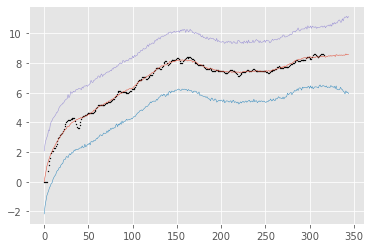

In [85]:
fig1, ax1 = plt.subplots()

ax1.plot((case_predictions_w_obs_noise.mean(axis=0)),linewidth=.5)
ax1.plot((np.quantile(case_predictions_w_obs_noise,axis=0,q=.025)),linewidth=.5)
ax1.plot((np.quantile(case_predictions_w_obs_noise,axis=0,q=.975)), linewidth=.5)

ax1.scatter(df_train.X.values,(df_train.Y.values),color='black',s=.75)
#ax1.plot(np.median(predictions,axis=0))

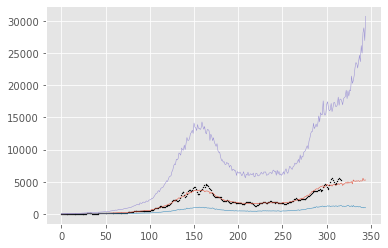

In [86]:
fig1, ax1 = plt.subplots()

ax1.plot(np.exp(case_predictions_w_obs_noise.mean(axis=0)),linewidth=.5)
ax1.plot(np.exp(np.quantile(case_predictions_w_obs_noise,axis=0,q=.1)),linewidth=.5)
ax1.plot(np.exp(np.quantile(case_predictions_w_obs_noise,axis=0,q=.9)), linewidth=.5)

ax1.scatter(df_train.X.values,np.exp(df_train.Y.values),color='black',s=.75)
#ax1.plot(np.median(predictions,axis=0))

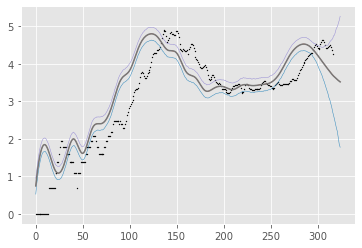

In [87]:

fig1, ax1 = plt.subplots()

ax1.plot(predictions_w_obs_noise.mean(axis=0),linewidth=.5)
ax1.plot(np.quantile(predictions_w_obs_noise,axis=0,q=.025),linewidth=.5)
ax1.plot(np.quantile(predictions_w_obs_noise,axis=0,q=.975),linewidth=.5)

ax1.scatter(df_train.X.values,df_train.D.values,color='black',s=.75)
ax1.plot(np.median(predictions,axis=0))


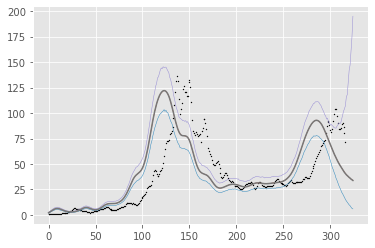

In [88]:
fig1, ax1 = plt.subplots()

ax1.plot(np.exp(predictions_w_obs_noise.mean(axis=0)),linewidth=.5)
ax1.plot(np.exp(np.quantile(predictions_w_obs_noise,axis=0,q=.025)),linewidth=.5)
ax1.plot(np.exp(np.quantile(predictions_w_obs_noise,axis=0,q=.975)),linewidth=.5)

ax1.scatter(df_train.X.values, np.exp(df_train.D.values), color='black',s=.75)
ax1.plot(np.exp(np.median(predictions,axis=0)))